# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Задача: построить модель для определения региона нефтедобычи с наибольшей средней прибылью, в котором вероятность убытков составит меньше 2.5%. 

Ход исследования:

- загрузить библиотеки
- выгрузка данных
- подготовка данных
- ML
- расчет прибыли/убытков
- вывод


## Загрузка и подготовка данных

In [6]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import warnings


from numpy.random import RandomState
from scipy import stats as st
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [7]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [8]:
# извлечем данные

geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [9]:
geo_data_0 = geo_data_0.drop(['id'], axis = 1)
geo_data_1 = geo_data_1.drop(['id'], axis = 1)
geo_data_2 = geo_data_2.drop(['id'], axis = 1)

In [10]:
geo_data_0['key'] = 0
geo_data_1['key'] = 1
geo_data_2['key'] = 2
df = pd.concat([geo_data_0, geo_data_1, geo_data_2], ignore_index=True, sort= False)

In [11]:
df.sample(5)

,f0,f1,f2,product,key
75090,1.558247,-0.718464,5.015303,123.546320,0
29463,-0.995100,0.255685,2.945942,78.104209,0
103399,-12.458808,-8.346958,1.002830,30.132364,1
279832,-2.381938,0.010175,5.036438,108.575302,2
272426,0.839778,0.507717,6.597029,47.674180,2


данные выгрузились корректно.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       300000 non-null  float64
 1   f1       300000 non-null  float64
 2   f2       300000 non-null  float64
 3   product  300000 non-null  float64
 4   key      300000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 11.4 MB


In [13]:
df.isna().sum()

f0         0
f1         0
f2         0
product    0
key        0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [16]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
df.describe(include='all')

,f0,f1,f2,product,key
count,"300,000.00","300,000.00","300,000.00","300,000.00","300,000.00"
mean,0.55,-1.52,2.50,85.44,1.00
std,5.32,3.90,2.92,46.52,0.82
min,-31.61,-26.36,-12.09,0.00,0.00
25%,-1.00,-2.48,0.65,52.67,0.00
50%,0.35,-0.23,2.49,84.04,1.00
75%,1.76,0.68,4.34,124.17,2.00
max,29.42,18.73,16.74,190.03,2.00


<AxesSubplot:>

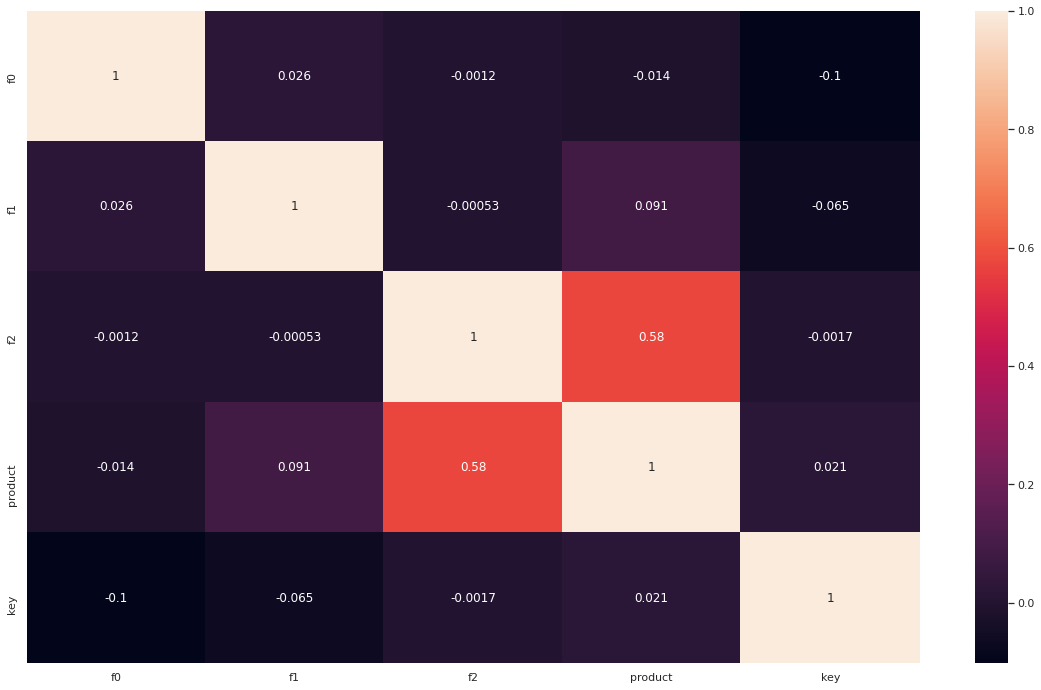

In [17]:
spearman = df.corr(method='spearman')
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(data=spearman,annot=True)

In [18]:
geo_data_0 = df[df['key'] == 0]
geo_data_1 = df[df['key'] == 1]
geo_data_2 = df[df['key'] == 2]

Все три дата сета имеют 100к строк и 5 столбцов, 4 из которых количественные и 1 категориальный(id) который мы убрали как неинформативный. Распределение нормальное. Пропусков, дубликатов нет. Есть кореляция в 0 и 1 регионе - объём запасов продукта в скважине и признак f2, в 1 регионе зависимость очень высокая. Данные синтетические и у нас нет определения признака f2.  
Признак product - целевой. 

## Обучение и проверка модели.

Датафрейма у нас три, действия однотипные - напишем функцию которая берет на вход дф, определяет признаки, разбивает данные на обучающую и валидационную выборки, обучает модель линейной регресси, предказывает целевой признак, расчитывает rmse и возвращает предсказания и правильные ответы вал. выборки а так же средний запас предсказанного сырья в скважине.

In [19]:
def ml_linear (data):
    features = data.drop(['product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features,target,test_size=.25, random_state=12345)
    model = LinearRegression().fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(predicted_valid, target_valid))**(0.5)
    average_product = sum(predicted_valid) / len(predicted_valid)
    target_valid = target_valid.reset_index(drop=True)
    predicted_valid = pd.Series (predicted_valid)
    return (predicted_valid, target_valid, rmse, average_product)

In [20]:
# сохраним необходимые данные в отдельные переменнные

predicted_valid_0, target_valid_0, rmse_0, average_product_0 = ml_linear(geo_data_0)
predicted_valid_1, target_valid_1, rmse_1, average_product_1 = ml_linear(geo_data_1)
predicted_valid_2, target_valid_2, rmse_2, average_product_2 = ml_linear(geo_data_2)


In [21]:
# выведем на экран предсказания среднего запаса сырья  в скважине тыс. баррелей и rmse модели по регионам

print ('Средний запас предсказанного сырья для Региона_0 =', average_product_0.round(), ', rmse модели:', rmse_0.round())
print()
print ('Средний запас предсказанного сырья для Региона_1 =', average_product_1.round(), ', rmse модели:', rmse_1.round())
print()
print ('Средний запас предсказанного сырья для Региона_2 =', average_product_2.round(), ', rmse модели:', rmse_2.round())


Средний запас предсказанного сырья для Региона_0 = 93.0 , rmse модели: 38.0

Средний запас предсказанного сырья для Региона_1 = 69.0 , rmse модели: 1.0

Средний запас предсказанного сырья для Региона_2 = 95.0 , rmse модели: 40.0


Средний запас предсказанного запаса сырья больше для 0 и 2 регионов, но модель региона 1 имеет самый низкий RMSE, что говорит нам о том, что предсказания в этом регионе самые точные.

## Подготовка к расчёту прибыли

In [22]:
# обозначим константные переменные 

BUDGET = 10**10
POINTS = 500
BEST_POINTS = 200
INCOME_PER_UNIT = 450000

In [23]:
# выведем средний объем скважины тыс. баррелей для безубыточной разработки сырья 

print ('Средний объем сырья для безубыточной разработки новой скважины =', round(BUDGET/BEST_POINTS/INCOME_PER_UNIT))

Средний объем сырья для безубыточной разработки новой скважины = 111


Ни один из регионов, по предсказаниям модели в среднем, не имеет достаточного запаса сырья для безубыточного производства. Продолжим исследования и расчитаем риски и прибыль.

## Расчёт прибыли и рисков 

In [24]:
# функция расчета прибыли

def profit_all (target, probabilities, count, INCOME_PER_UNIT, BUDGET):
    probabilities_sorted = probabilities.sort_values(ascending=False)
    selected = target[probabilities_sorted.index][:count]
    return int(INCOME_PER_UNIT * selected.sum() - BUDGET)

In [25]:
# основная функция для расчета средней прибыли, 95%- доверительного интервала и риска убытков для трех регионов

def final_calculation (target, predicted,POINTS, BEST_POINTS, INCOME_PER_UNIT, BUDGET):
    state = np.random.RandomState(12345)
    profit = []
    for row in range(1000):
        target_subsample = target.sample(n = POINTS, replace=True, random_state=state)
        predicted_subsumple = predicted[target_subsample.index]
        profit.append(profit_all(target_subsample, predicted_subsumple, BEST_POINTS, INCOME_PER_UNIT, BUDGET))
    profit = pd.Series(profit)
    profit_mean = int(sum(profit) / len(profit))
    lower = int(profit.quantile(q=0.025))
    upper = int(profit.quantile(q=0.975))
    risk = st.percentileofscore(profit, 0)
    return profit_mean, lower, upper, risk

In [26]:
# применим функцию для регионов 

profit_mean_0, lower_0, upper_0, risk_0 = final_calculation(target_valid_0, predicted_valid_0, POINTS, BEST_POINTS, INCOME_PER_UNIT, BUDGET)
profit_mean_1, lower_1, upper_1, risk_1 = final_calculation(target_valid_1, predicted_valid_1, POINTS, BEST_POINTS, INCOME_PER_UNIT, BUDGET)
profit_mean_2, lower_2, upper_2, risk_2 = final_calculation(target_valid_2, predicted_valid_2, POINTS, BEST_POINTS, INCOME_PER_UNIT, BUDGET)

In [27]:
# создадим дф для финальной визуализации

data = {'регион':['Регион_0', 'Регион_1', 'Регион_2'], 'средняя прибыль':[profit_mean_0,profit_mean_1, profit_mean_2],'интервал начало':[lower_0,lower_1,lower_2], 'интервал конец':[upper_0,upper_1,upper_2], 'риск убытков %':[risk_0,risk_1,risk_2 ]} 
df_final = pd.DataFrame(data) 

In [28]:
print (df_final)

     регион  средняя прибыль  интервал начало  интервал конец  риск убытков %
0  Регион_0        425938526       -102090093       947976352            6.00
1  Регион_1        515222772         68873225       931547590            1.00
2  Регион_2        435008362       -128880546       969706953            6.40


Только Регион_1 подходит для нашей задачи как регион где вероятность убытка = 1%, так же отметим более 'надежный' доверительный интервал и высокую среднюю прибыль в этом регионе. 

#### Финальный вывод.

 Были изучены три региона для потенциальной нефтедобычи. Данные синтетические, без дефектов. Для обучения использовали модель линейной регрессии. 
Предсказания модели определили Регион 0 и Регион 2 - как регионы с наибольшим средним запасом сырья - в этих же регионах мы получили высокое значение среднеквадратичной ошибки модели, а значит более низкое качество предсказаний. При финальной проверке техникой бутстреп с заданными параметрами мы выяснили - только Регион_1 имеет вероятность убытка < 2.5% , и наиболее высокий средний доход.  

#### Рекомендуется проводить разработку скважин в Регионе_1. 